In [1]:
import os
import random
from PIL import Image
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Polygon, Circle
import json
import csv
from matplotlib.collections import PatchCollection
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import copy
import cv2

In [2]:
def GetFilesFromDirectory(directory):
    allfiles = []
    imids = []
    for root,dirs,files in os.walk(directory):
        for filespath in files:
            full_filepath = os.path.join(root, filespath)
            allfiles.append(full_filepath)
            imids.append(filespath)
        return imids

def create_polygon(box):
    xA,yA,w,h = box
    A = (xA,yA)
    B = (xA+w,yA)
    C = (xA+w, yA+h)
    D = (xA, yA+h)
    poly = Polygon([A,B,C,D])
    return poly

TomateLiquide = ['Soupe à la tomate', 'Sauce tomate (à part)', 'Sardines sauce tomate', 'Raviolis sauce tomate',
           'Verre de Jus de tomate']
TomateSolide = ['Tomates séchées','Tomate Mozzarella (Salade Caprese plat complet)','Tartine fromage tomate jambon', 
          'Tomate farcie', 'Tomate à la provençale', 'Tomates (entières)', 'Tomates cerises', 'Tomates (coupées)'
              ]

In [3]:
class FoodLoader(Dataset):
    
    def __init__(self, root = 'data', transform = None, mode = None):
             
        
        self.root = root
        self.transform = transform
        self.folderpath = os.path.join(root, 'assignment_imgs')
        
        # Load images
        self.imgs = GetFilesFromDirectory(self.folderpath)
        if mode:
            l = len(self.imgs)
            sep1 = l*2//3
            sep2 = l*5//6
            if mode == 'train':
                self.imgs = self.imgs[:sep1]
            if mode == 'val':
                self.imgs = self.imgs[sep1:sep2]
            if mode == 'test':
                self.imgs = self.imgs[sep2:]
        
        # Load annotations 
        annspath = os.path.join(root, 'img_annotations.json')
        with open(annspath) as f:
            self.anns = json.load(f, encoding='utf8')
        
        # Load mapping
        mappingpath = os.path.join(root, 'label_mapping.csv')
        with open(mappingpath, encoding="utf8") as infile:
            reader = csv.reader(infile)
            self.id2food = {rows[0]:rows[1] for rows in reader}
        with open(mappingpath, encoding="utf8") as infile:
            reader = csv.reader(infile)
            self.id2fooden = {rows[0]:rows[2] for rows in reader}
        
    def showanns(self, imagename = None, imageid = None):
        if imageid:
            imagename = self.imgs[imageid]
        elif imagename:
            imagename = imagename
        else:
            imagename = random.choice(self.imgs)
        img_path = os.path.join(self.folderpath, imagename)
        objects = self.anns[imagename]
        plt.figure(figsize= (15,20))
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        ax = plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        color = []
        circles = []
        r = 2
        for obj in objects:
            if obj['is_background']: continue
            c = (np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0]
            poly = create_polygon(obj['box'])
            polygons.append(poly)
            color.append(c)
            circle = Circle((obj['box'][0], obj['box'][1]), r)
            classid = obj['id']
            plt.text(obj['box'][0]+2, obj['box'][1]-5, self.id2food[classid],  bbox=dict(facecolor=c, alpha=0.7))
            circles.append(circle)

        p = PatchCollection(polygons, facecolors=color, linewidths=0, alpha=0.4)
        ax.add_collection(p)
        p = PatchCollection(polygons, facecolors='none', edgecolors=color, linewidths=2)
        ax.add_collection(p)
        p = PatchCollection(circles, facecolors='red')
        ax.add_collection(p)
    
    def __getitem__(self, idx):
        
        # load images and label
        
        imagename = self.imgs[idx]
        img_path = os.path.join(self.folderpath, imagename)
        img = Image.open(img_path).convert("RGB")
        has_tomate = torch.tensor(0)
        objects = self.anns[imagename]
        
        # Naive labeling.
        for obj in objects:
            classid = obj['id']
            food = self.id2food[classid]
            if food in TomateSolide:
                has_tomate = torch.tensor(1)
                break
        
        if self.transform:
            img = self.transform(img)
        
        return img, has_tomate, imagename
    
    def __len__(self):
        return len(self.imgs)

In [4]:
tr_train = transforms.Compose([transforms.RandomChoice([transforms.Resize(256),transforms.Resize(224),transforms.Resize(288)]),
                         transforms.RandomHorizontalFlip(p=0.5),
                         transforms.RandomVerticalFlip(p=0.5),
                         transforms.CenterCrop(224), 
                         transforms.ToTensor(),
                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

tr_val = transforms.Compose([transforms.Resize(256),
                         transforms.CenterCrop(224), 
                         transforms.ToTensor(),
                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = FoodLoader(transform = tr_train, mode = 'train')
val_dataset = FoodLoader(transform = tr_val, mode = 'val')
test_dataset = FoodLoader(transform = tr_val, mode = 'test')

We have class inbalance (Ratio 5)


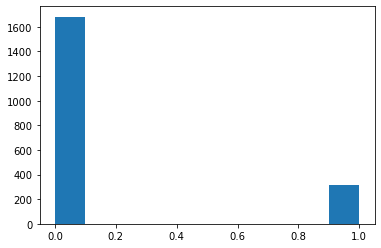

In [5]:
l = []
for img, label,imname in train_dataset:
    l.append(label)
plt.hist(l)
print('We have class inbalance (Ratio 5)')

(array([1682.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        318.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <a list of 10 Patch objects>)


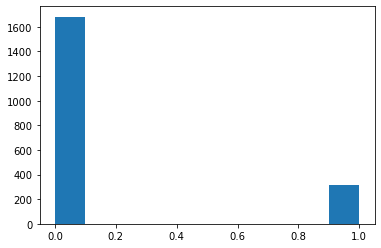

In [6]:
print(plt.hist(l))

In [7]:
for idx, food in train_dataset.id2food.items():
    if "tomate" in food.lower():
        print(food)

Verre de Jus de tomate
Tomates (coupées)
Tomates cerises
Tomates (entières)
Tomate à la provençale
Tomate farcie
Tartine fromage tomate jambon
Raviolis au fromage (sans sauce tomate)
Raviolis sauce tomate
Part de quiche provençale à la tomate
Sardines sauce tomate
Tomate Mozzarella (Salade Caprese plat complet)
Sauce tomate (à part)
Tomates séchées
Soupe à la tomate


In [8]:
for idx, food in train_dataset.id2fooden.items():
    if "tomato" in food.lower():
        print(food)

Tomato juice
Tomatoes
Cherry tomatoes
Tomatoe whole
Stuffed Tomatoes
Stuffed tomatoes
Ravioli with tomato sauce
Quiche provence w. tomato
Sardine tomato sauce
Tomato Mozzarella
Tomato sauce
Dried tomatoes
Tomato soup


In [9]:
# Model VGG 
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier._modules['6'] = nn.Linear(in_features = 4096, out_features = 2, bias = True)
vgg_model.to('cuda')
print('OK using pretrained vgg16')

OK using pretrained vgg16


In [10]:
# Choose the hyperparameters for training: 
num_epochs = 50
batch_size = 5

# Training criterion. 
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.,5.]).to('cuda'))

optimizer = torch.optim.Adam(vgg_model.parameters(), lr=1e-4)

In [11]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, train_dataset, val_dataset):
    train_error = []
    val_error = []
    train_acc = []
    val_acc = []
    best_acc = 0
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
    for epoch in range(num_epochs):
        model.train()
        epoch_average_loss = 0.0 
        epoch_val_loss = 0.0
        epoch_train_correct = 0.0
        epoch_val_correct = 0.0
        
        for (X_batch, y_real, imagename) in train_loader:
            y_pre = model(X_batch.to('cuda'))
            loss = criterion(y_pre, y_real.to('cuda'))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(y_pre.data, 1)
            epoch_train_correct += (predicted == y_real.to('cuda')).sum() 
            epoch_average_loss += loss.item() * batch_size / len(train_dataset)
        epoch_train_acc = epoch_train_correct / len(train_dataset)
        train_error.append(epoch_average_loss)
        train_acc.append(epoch_train_acc)
        
        model.eval()
        with torch.no_grad():
            for (X_batch, y_real, imagename) in val_loader:
                y_pre = model(X_batch.to('cuda'))
                loss = criterion(y_pre, y_real.to('cuda'))
                optimizer.zero_grad()
                _, predicted = torch.max(y_pre.data, 1)
                epoch_val_correct += (predicted == y_real.to('cuda')).sum()
                epoch_val_loss += loss.item() * batch_size / len(val_dataset)
        epoch_val_acc = epoch_val_correct / len(val_dataset)
        val_error.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f} , Train accuracy: {:.4f}, Val accuracy: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc))
        if best_acc < epoch_val_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)
    return train_error, val_error, train_acc, val_acc

In [12]:
TRAIN = False
if TRAIN:
    train_error, val_error, train_acc, val_acc = train(num_epochs, batch_size, criterion, optimizer, vgg_model, train_dataset, val_dataset)
    torch.save(vgg_model.state_dict(), 'output2.pth')
else:
    vgg_model.load_state_dict(torch.load('vgg_model1.pth'))
    print('Successfully loaded state dict')

Successfully loaded state dict


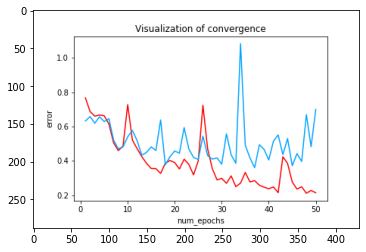

In [13]:
# plot the training error wrt. the number of epochs: 
if TRAIN:
    plt.plot(range(1, num_epochs+1), train_error, c='blue')
    plt.plot(range(1, num_epochs+1), val_error, c='orange')
    plt.xlabel("num_epochs")
    plt.ylabel("error")
    plt.title("Visualisation of convergence")
    plt.savefig('Visualisation_of_convergence2.png')
else:
    im = cv2.imread("Visualisation_of_convergence.png")
    plt.imshow(im)

In [14]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):
    model.eval()
    confusion = np.zeros((2,2), dtype = int)
    list_of_errors = []
    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset, batch_size= 1)
        for idx, (images, labels, imagenames) in enumerate(dataloader):
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            confusion[predicted.cpu().numpy()[0],labels.cpu().numpy()[0]]+=1
            correct += (predicted == labels).sum()
            if (predicted == labels).sum() ==0:
                list_of_errors.append((imagenames[0],predicted, labels))
    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))
    print(confusion)
    return confusion, list_of_errors

In [15]:
confusion, list_of_errors = accuracy(train_dataset, vgg_model)
confusion

Accuracy of the model : 93.70 %
[[1579   23]
 [ 103  295]]


array([[1579,   23],
       [ 103,  295]])

Text(0.5, 1.0, 'Train confusion')

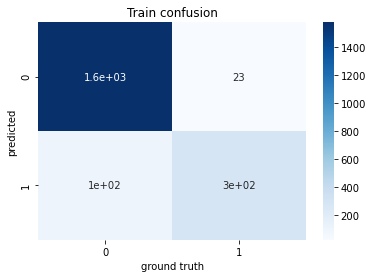

In [16]:
import seaborn as sns
heatmap = sns.heatmap(confusion, annot=True, cmap="Blues")
heatmap.set_xlabel('ground truth')
heatmap.set_ylabel('predicted')
plt.title('Train confusion')

In [17]:
confusion, list_of_errors = accuracy(val_dataset, vgg_model)
confusion

Accuracy of the model : 89.20 %
[[381  16]
 [ 38  65]]


array([[381,  16],
       [ 38,  65]])

In [18]:
confusion, list_of_errors = accuracy(test_dataset, vgg_model)
confusion

Accuracy of the model : 91.80 %
[[373  15]
 [ 26  86]]


array([[373,  15],
       [ 26,  86]])

In [19]:
def show_cam_on_image(image, feature_map):
    ### first construct the heatmap
    heatmap = cv2.applyColorMap(np.uint8(np.round(255 * feature_map)), cv2.COLORMAP_HSV)
    heatmap = np.float64(heatmap) / 255
    
    ### normalize the image
    image -= image.min()
    image /= (image.max() + 1e-6)
    
    ### final image
    final_image = heatmap + image
    final_image -= final_image.min() # rescaling in [0, 1] (1)
    final_image /= (final_image.max() + 1e-6) # rescaling in [0, 1] (2)
    
    ### plot
    plt.figure(figsize = (15, 15))
    plt.imshow(final_image)

In [20]:
class Hook():
    '''Class that stores the input and output of a layer during forward/backward pass.'''
    
    def __init__(self, module):
        self.hook = module.register_hook(self.save_gradient)
        
    def save_gradient(self, gradient):
        self.gradients = gradient

In [21]:
def grad_cam(model, image, target_layer, desired_class):

    ### set the model in evaluation mode
    model.eval()

    ### forward-propagate the image throw the 'features' module
    output_features = image # input image
    for layer_index, module in model.features._modules.items(): # loop over the layers of model.features 
        output_features = module(output_features) # feed the network
        if layer_index == target_layer: # if it is the layer of interest, we apply 'hook' function to store in/ouputs
            hook = Hook(output_features) # hook the layer of interest
            output_target_layer = output_features[0, :, :, :].detach().cpu().numpy() # output for the layer of interest

    ### forward-propagate the image throw the 'classifier' module
    output = model.classifier(output_features.view(output_features.size(0), -1)).cpu() # feed the 'classifier' module

    ### set the gradients to zero
    model.features.zero_grad() # sets gradients of all model parameters to zero (in 'features' module)
    model.classifier.zero_grad() # sets gradients of all model parameters to zero (in 'classifier' module)

    ### one hot encoding for the desired class
    one_hot = torch.tensor(np.zeros(output.size())) # initialize one hot encoding 
    one_hot[0, desired_class] = 1 # set the desired class to 1
    one_hot = torch.sum(one_hot * output) # element wise multiplication in order to achieve grad
    one_hot.backward() # backpropagate the message

    ### compute the coarse Grad-CAM localization
    gradient_values = hook.gradients.cpu().numpy()[0, :, :, :] # extract the gradient values using the hook class
    global_average_pooled_gradients = gradient_values.reshape((gradient_values.shape[0], -1)).mean(axis=1)
    L_grad_cam = np.zeros((14, 14))
    for i in range(512):
        L_grad_cam += global_average_pooled_gradients[i] * output_target_layer[i]
    L_grad_cam = np.maximum(L_grad_cam, 0) # apply ReLU

    ### resize the L_grad_cam
    L_grad_cam = cv2.resize(L_grad_cam, (224, 224))
    L_grad_cam -= L_grad_cam.min() # scale
    L_grad_cam /= (L_grad_cam.max() + 1e-6)
    
    return L_grad_cam


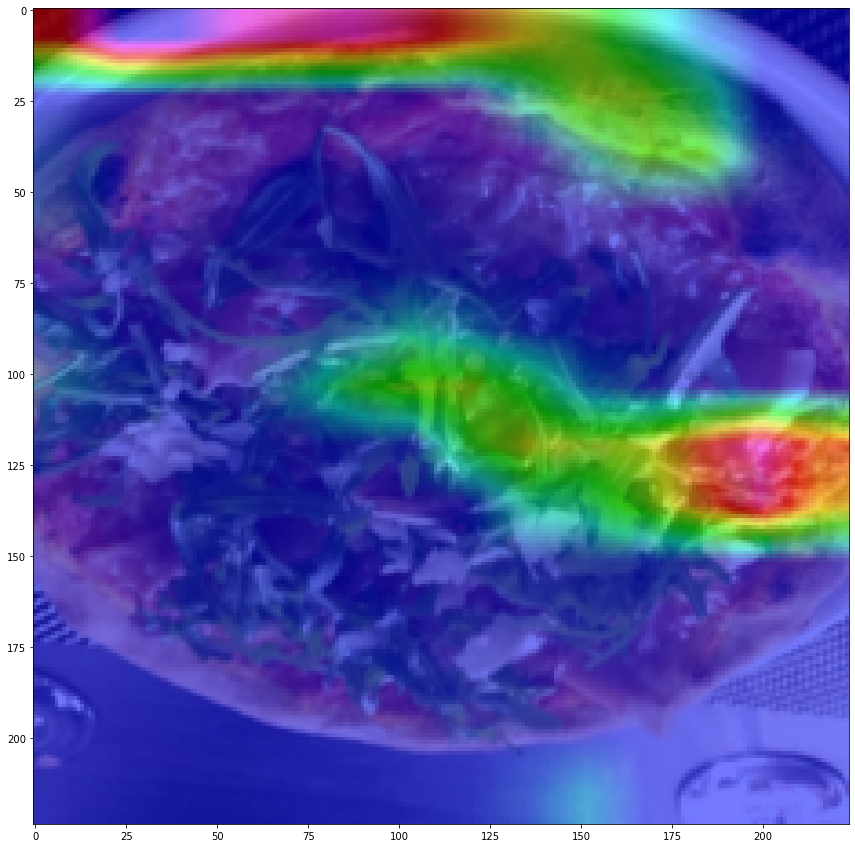

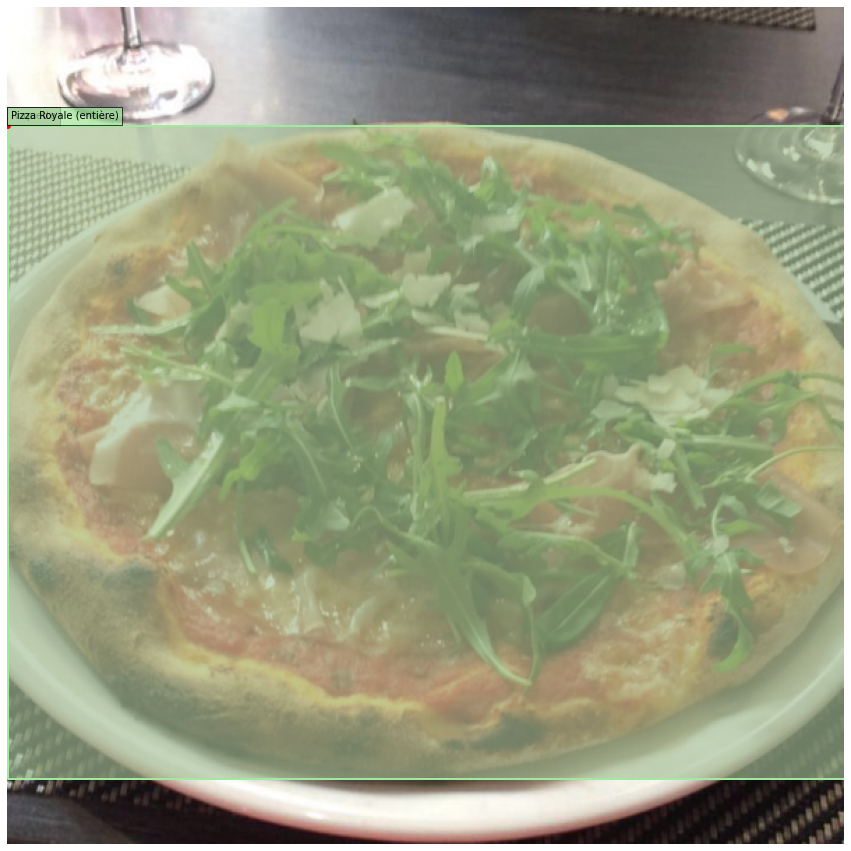

In [22]:
target_layer = '29' # after the ReLU ('rectified convolutional feature map')
desired_class = 1

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = True)
for (X_batch, y_real, imagename) in train_loader:
    L_grad_cam = grad_cam(vgg_model, X_batch.to('cuda'), target_layer, desired_class)
    new_image = X_batch[0].numpy()
    new_image = np.moveaxis(new_image, 0, 2)
    show_cam_on_image(new_image, L_grad_cam)
    val_dataset.showanns(imagename[0])
    break

'33007_2017_04_11_19_39_22.jpg' -> Tomate dans la salade composée

'54bbd07bd3393b329a952efe2574df14.jpeg' -> Tomate dans la salade de pomme de terre

'201_2016_09_08_12_02_43.jpg' -> Erreur de Label (label sur le verre d'eau ?)


In [ ]:
imgid = random.choice(train_dataset.imgs)
train_dataset.showanns(imgid)

In [ ]:
train_dataset.showanns('33007_2017_04_11_19_39_22.jpg')
train_dataset.showanns('54bbd07bd3393b329a952efe2574df14.jpeg')

In [ ]:
for key,food in train_dataset.id2food.items():
    if 'tomate' in food.lower():
        print(food)

In [ ]:
list(model_resnet18.children())[7]

In [ ]:
# Model Resnet
model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 2)
model_resnet18.to('cuda')
print('OK using pretrained resnet18')